# **Machine Learning (ML) Methods**

**Unsupervised Learning**

**KMeans clustering**

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import ast

In [6]:
# Load your data
df = pd.read_csv("lightcast_job_postings.csv")

C:\Users\prabu\AppData\Local\Temp\ipykernel_62388\4181052193.py:2: DtypeWarning: Columns (19,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("lightcast_job_postings.csv")


**Clean and Preparing Reference Label Columns**

In [7]:
# 1. Imports
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

In [26]:
# Combine fields
df['TITLE_CLEAN'] = df['TITLE_CLEAN'].fillna('unknown').astype(str).str.strip().str.lower()
df['SOFTWARE_SKILLS_NAME'] = df['SOFTWARE_SKILLS_NAME'].fillna('').astype(str).str.lower()
df['ONET_NAME'] = df['ONET_NAME'].fillna('').astype(str).str.lower()
df['BODY'] = df['BODY'].fillna('').astype(str).str.lower()
# Combine text fields for TF-IDF
df['combined_text'] = df['TITLE_CLEAN'] + ' ' + df['SOFTWARE_SKILLS_NAME'] + ' ' + df['ONET_NAME'] + ' ' + df['BODY']

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# Vectorize
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = tfidf.fit_transform(df['combined_text']).toarray()

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_tfidf)

In [36]:
# KMeans
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Evaluation
reference_label = 'NAICS2_NAME'  # Try all 3 and compare
df_eval = df[[reference_label, 'cluster']].dropna()
ari = adjusted_rand_score(df_eval[reference_label], df_eval['cluster'])
nmi = normalized_mutual_info_score(df_eval[reference_label], df_eval['cluster'])
# sil_score = silhouette_score(X_scaled, df['cluster'])

print(f"Adjusted Rand Index ({reference_label}): {ari:.3f}")
print(f"Normalized Mutual Info Score ({reference_label}): {nmi:.3f}")
# print(f"Silhouette Score: {sil_score:.3f}")


Adjusted Rand Index (NAICS2_NAME): 0.019
Normalized Mutual Info Score (NAICS2_NAME): 0.050


**TF-IDF Based Clustering (Bonus)**

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Use job descriptions or skills (cleaned text column)
corpus = df['BODY'].fillna('')  # or use 'TITLE_RAW' or 'SKILLS_NAME'

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = vectorizer.fit_transform(corpus)

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
tfidf_labels = kmeans.fit_predict(X_tfidf)

# Add cluster labels
df['TFIDF_Cluster'] = tfidf_labels

**TF-IDF Vectorization**

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use 'BODY' as the text source (fallback to 'TITLE_RAW' if BODY is too sparse)
df['TITLE_CLEAN'] = df['TITLE_CLEAN'].fillna('')

vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    ngram_range=(2, 2),  # bigrams
    min_df=5
)
X_tfidf = vectorizer.fit_transform(df['TITLE_CLEAN'])

**KMeans Clustering on TF-IDF**

In [15]:
from sklearn.cluster import KMeans

k_tfidf = 3  # or test different values like before
kmeans_tfidf = KMeans(n_clusters=k_tfidf, random_state=42)
df['TFIDF_Cluster'] = kmeans_tfidf.fit_predict(X_tfidf)

**Top Terms per Cluster**

In [16]:
exclude = {'experience', 'work', 'job'}
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans_tfidf.cluster_centers_.argsort()[:, ::-1]

for i in range(k_tfidf):
    filtered = [terms[ind] for ind in order_centroids[i]
                if terms[ind] not in exclude][:10]
    print(f"Cluster {i} top filtered terms: {', '.join(filtered)}")


Cluster 0 top filtered terms: data analyst, data analytics, business intelligence, senior data, intelligence analyst, business analyst, solution architect, analyst ii, functional consultant, data modeler
Cluster 1 top filtered terms: data science, science analyst, analyst data, analyst iii, senior data, analyst ii, lead analyst, analytics analyst, data products, associate data
Cluster 2 top filtered terms: enterprise architect, senior enterprise, principal enterprise, sr enterprise, architect remote, architect cleared, lead enterprise, global enterprise, architect salesforce, architect iv


**Visualize TF-IDF Clusters**

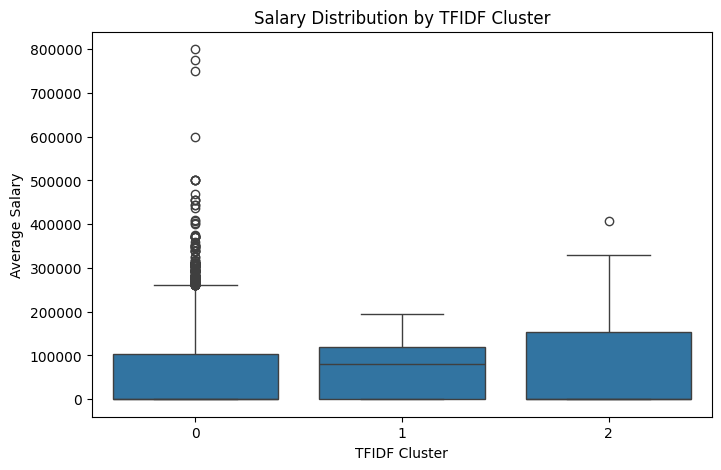

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot salary by TFIDF cluster
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='TFIDF_Cluster', y='SALARY_AVG')
plt.title('Salary Distribution by TFIDF Cluster')
plt.xlabel('TFIDF Cluster')
plt.ylabel('Average Salary')
plt.show()

**Industry Distribution in TF-IDF Clusters**

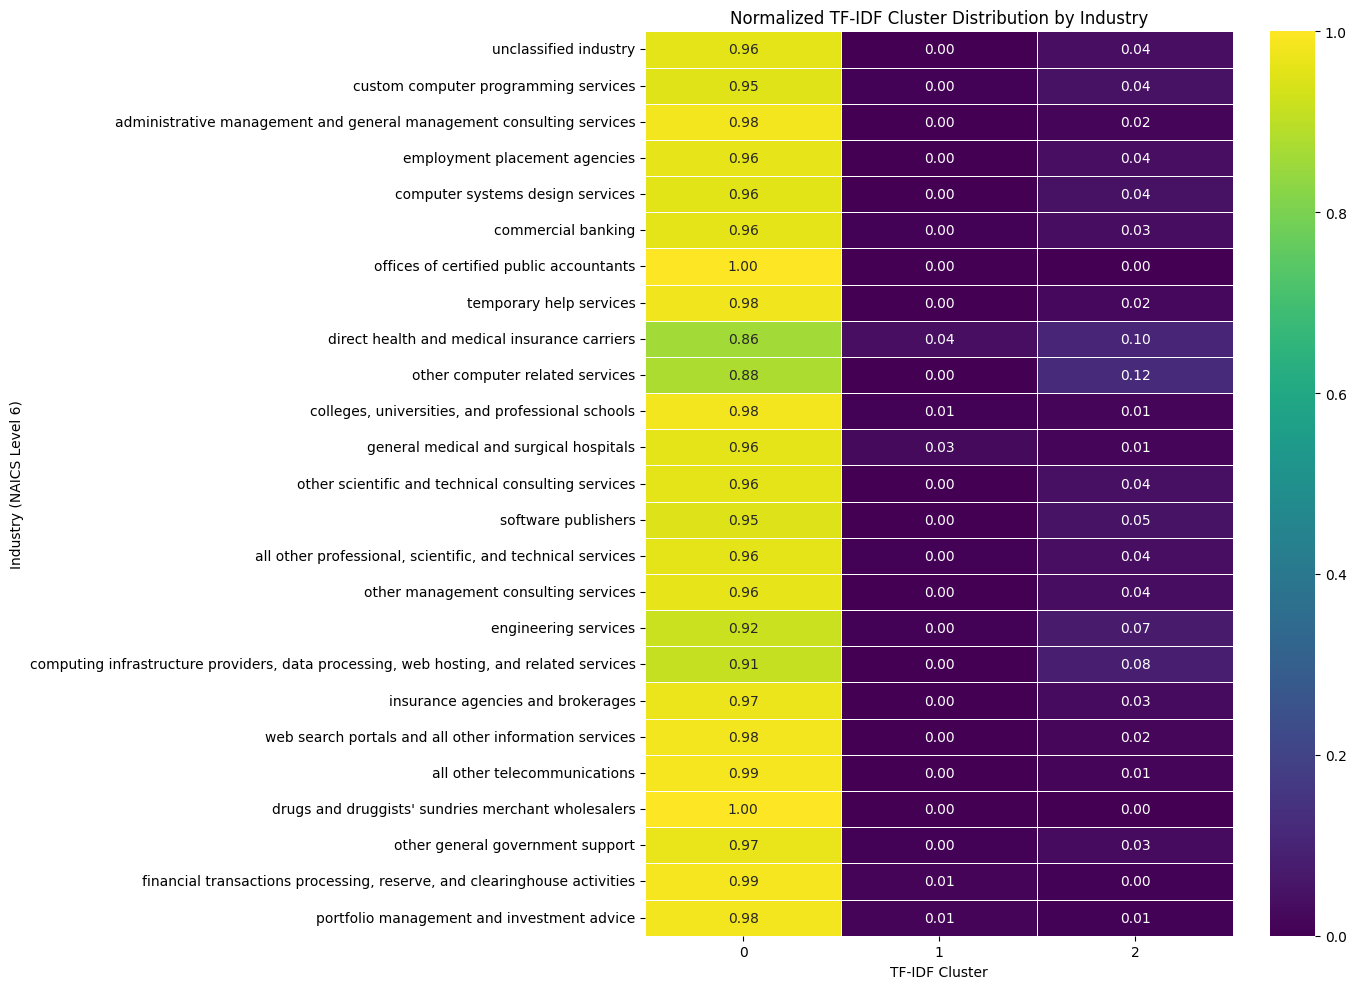

In [18]:
# Step 1: Compute normalized cluster distribution per industry
industry_cluster = (
    df.groupby(['NAICS_2022_6_NAME', 'TFIDF_Cluster'])
    .size()
    .unstack(fill_value=0)
)

# Step 2: Normalize by industry (row-wise proportions)
industry_cluster_normalized = industry_cluster.div(industry_cluster.sum(axis=1), axis=0)

# Step 3: Filter top industries by total count (optional but recommended for clarity)
top_industries = df['NAICS_2022_6_NAME'].value_counts().head(25).index
filtered = industry_cluster_normalized.loc[top_industries]

# Step 4: Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(filtered, cmap='viridis', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Normalized TF-IDF Cluster Distribution by Industry")
plt.xlabel("TF-IDF Cluster")
plt.ylabel("Industry (NAICS Level 6)")
plt.tight_layout()
plt.show()